## Імпорт бібліотек та завантаження даних

In [1]:
import pandas as pd
import torch

from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

from matplotlib import pyplot as plt

c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\pytorch_forecasting\models\base\_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
import pandas as pd
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT633XHFtkq1Ea7cXs8KUClbApO3RN-eB_y9yJIDP9MDAxgXzxmoaUhb9FUOw-nR0baY6aEr3Yjv76s/pub?gid=1610362465&single=true&output=csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Завдання

На прикладі завдання в класі
1. Розділіть дані на тренувальну та валідаційну вибірку
2. Утворіть `TimeSeriesDataSet`, вибравши ознаки, які вважаєте доцільними, для тренувальної та тестувальної вибірок.
3. Трансформуйте датасети у даталоадери.
4. Визначте модель `TemporalFusionTransformer` та натренуйте її.
5. Візулазіуйте результати

In [4]:
data['datetime'] = data['dteday'].astype(str) + ' ' + data['hr'].astype(str) + ':00:00'
data = data[['datetime', 'hr', 'temp', 'weekday', 'hum', 'cnt']]

In [5]:

data['datetime'] = pd.to_datetime(data['datetime'])
data['series_id'] = 0

In [6]:
data["Time_index"] = (data['datetime']-data['datetime'].min()).dt.total_seconds() // 3600
data['Time_index'] = data['Time_index'].astype(int)

In [7]:
data.head(5)

,datetime,hr,temp,weekday,hum,cnt,series_id,Time_index
0,2011-01-01 00:00:00,0,0.24,6,0.81,16,0,0
1,2011-01-01 01:00:00,1,0.22,6,0.80,40,0,1
2,2011-01-01 02:00:00,2,0.22,6,0.80,32,0,2
3,2011-01-01 03:00:00,3,0.24,6,0.75,13,0,3
4,2011-01-01 04:00:00,4,0.24,6,0.75,1,0,4


In [8]:
max_encoded_length = 72
max_prediction_length = 24

In [12]:
cutoff = data['Time_index'].max() - max_prediction_length
df_train = data[data['Time_index'] <= cutoff]
df_test = data[data['Time_index'] > cutoff - max_encoded_length]

In [14]:
seriesDataset = TimeSeriesDataSet(
    df_train,
    time_idx="Time_index",
    target='cnt',
    group_ids=['series_id'],
    min_encoder_length=max_encoded_length,
    max_encoder_length=max_encoded_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['cnt', 'temp', 'hum'],
    time_varying_known_reals=['hr', 'weekday', 'Time_index'],
    allow_missing_timesteps=True
)

In [15]:
validationDataset = TimeSeriesDataSet.from_dataset(seriesDataset, df_test, stop_randomization=True)

In [16]:
batch_size = 64
train_dataset = seriesDataset.to_dataloader(train=True, batch_size=batch_size, num_workers=5)
validation_dataset = validationDataset.to_dataloader(train=False, batch_size=batch_size, num_workers=5)

In [17]:
tft_model = TemporalFusionTransformer.from_dataset(
    seriesDataset,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    loss=QuantileLoss(),
    learning_rate=1e-3
)

c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [19]:
checkpoint = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
lr_cb = LearningRateMonitor(logging_interval='epoch')

train_model = Trainer(max_epochs = 10,
                      accelerator='cpu',
                      callbacks=[early_stop, lr_cb, checkpoint],
                      enable_progress_bar=True)
train_model.fit(tft_model, train_dataloaders=train_dataset, val_dataloaders=validation_dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.9 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | sta

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 267/267 [01:40<00:00,  2.66it/s, v_num=0, train_loss_step=24.10, val_loss=26.60, train_loss_epoch=29.40]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 267/267 [01:40<00:00,  2.66it/s, v_num=0, train_loss_step=24.10, val_loss=26.60, train_loss_epoch=29.40]


In [20]:
best_model = TemporalFusionTransformer.load_from_checkpoint(checkpoint.best_model_path)
preds = best_model.predict(validation_dataset)

c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persi

In [21]:
preds=preds.flatten()

In [22]:
raw_preds = best_model.predict(validation_dataset, mode='raw', return_x=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Projects\Notebooks\my_forecasting_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


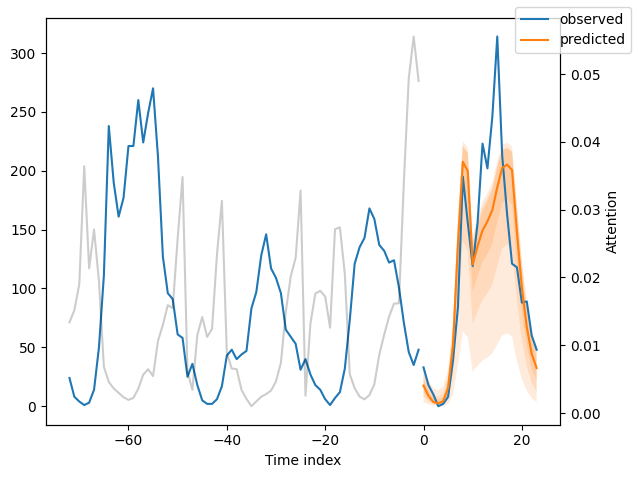

In [26]:
best_model.plot_prediction(raw_preds.x, raw_preds.output, idx=0)
plt.show()